# **Exploratory analysis of logistic data**

## 1\. Introduction

In this notebook, we will study and analyze delivery data from Loggi, a Brazilian startup founded in 2013 that has achieved unicorn status. Our goal is to generate insights that can help us better understand this data. Specifically, the data presented below is a subset that focuses on delivery operations in Brasília.

## 2\. Packages and libraries

In [ ]:
!pip3 install geopandas;

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import geopandas
import geopy
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## 3\. Data exploration

This piece of code performs two important tasks: data wrangling and reverse geocoding. Data wrangling refers to the process of cleaning and transforming raw data into a structured format that can be easily analyzed. Reverse geocoding, on the other hand, involves converting geographic coordinates (such as latitude and longitude) into a more understandable address format

In [ ]:

!wget -q 'https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json' -O deliveries.json
!wget -q 'https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv' - O deliveries-geodata.csv
!wget -q 'https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip' -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

deliveries_df = pd.DataFrame(data)

#Data Wrangling
    #Flattening nested data and merging it to the original dataframe
hub_origin_df = pd.json_normalize(deliveries_df['origin'])

deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)

deliveries_df = deliveries_df.drop('origin', axis=1)
deliveries_df = deliveries_df[['name', 'region', 'lng', 'lat', 'vehicle_capacity', 'deliveries']]
deliveries_df.rename(columns={'lng': 'hub_lng', 'lat': 'hub_lat'}, inplace=True)


deliveries_exploded_df = deliveries_df[['deliveries']].explode('deliveries')

deliveries_normalized_df = pd.concat([
    pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['size'])).rename(columns={'deliveries':'delivery_size'}),
    pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['point']['lng'])).rename(columns={'deliveries':'delivery_lng'}),
    pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['point']['lat'])).rename(columns={'deliveries':'delivery_lat'}),
], axis=1)

deliveries_df = deliveries_df.drop('deliveries', axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

    #HUB reverse Geocoding
hub_df = deliveries_df[['region', 'hub_lng', 'hub_lat']]
hub_df = hub_df.drop_duplicates().sort_values(by='region').reset_index(drop=True)

geolocator = Nominatim(user_agent='ebac_geocoder')
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

hub_df['coordinates'] = hub_df['hub_lat'].astype(str) + ', ' + hub_df['hub_lng'].astype(str)
hub_df['geodata'] = hub_df['coordinates'].apply(geocoder)

hub_geodata_df = pd.json_normalize(hub_df['geodata'].apply(lambda data: data.raw))
hub_geodata_df = hub_geodata_df[['address.town', 'address.suburb', 'address.city']]
hub_geodata_df.rename(columns={'address.town': 'hub_town', 'address.suburb': 'hub_suburb', 'address.city': 'hub_city'},inplace=True)
hub_geodata_df['hub_city'] = np.where(hub_geodata_df['hub_city'].notna(), hub_geodata_df['hub_city'], hub_geodata_df['hub_town'])
hub_geodata_df['hub_suburb'] = np.where(hub_geodata_df['hub_suburb'].notna(), hub_geodata_df['hub_suburb'], hub_geodata_df['hub_city'])
hub_geodata_df = hub_geodata_df.drop('hub_town', axis=1)

hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[['region', 'hub_suburb', 'hub_city']]

deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how='inner', on='region')
deliveries_df = deliveries_df[['name', 'region', 'hub_lng', 'hub_lat', 'hub_city', 'hub_suburb', 'vehicle_capacity', 'delivery_size', 'delivery_lng', 'delivery_lat']]

    #Deliveries reverse geocoding
deliveries_geodata_df = pd.read_csv('deliveries-geodata.csv')
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[['delivery_city', 'delivery_suburb']], how='inner', left_index=True, right_index=True)
deliveries_df.head()



,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


## 3\. Schema exploration


**Data type from each column**

In [ ]:
deliveries_df.dtypes

name                 object
region               object
hub_lng             float64
hub_lat             float64
hub_city             object
hub_suburb           object
vehicle_capacity      int64
delivery_size         int64
delivery_lng        float64
delivery_lat        float64
delivery_city        object
delivery_suburb      object
dtype: object

**Categoric atributes**

In [ ]:
deliveries_df.select_dtypes('object').describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708
hub_city,636149,3,Brasília,304708
hub_suburb,636149,3,Asa Sul,304708
delivery_city,634447,38,Brasília,148983
delivery_suburb,476264,167,Brasília,53795


**Numeric atributes**

In [ ]:
deliveries_df.drop(['name', 'region'], axis=1).select_dtypes('int64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


**Verifying any missing data**

In [ ]:
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
hub_city            False
hub_suburb          False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
dtype: bool

**Quantifying NaN data percentage in delivery city column**

In [ ]:
100 * (deliveries_df['delivery_city'].isna().sum() / len(deliveries_df))

0.26754738276724477

**Quantifying NaN data percentage in delivery suburb column**

In [ ]:
100 * (deliveries_df['delivery_suburb'].isna().sum() / len(deliveries_df))

25.133262804783158

**Most common cities**

In [ ]:
prop_df = deliveries_df[['delivery_city']].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_city       
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Guará                   0.055619
Lago Sul                0.045620
Sobradinho              0.045412
Lago Norte              0.040832
Gama                    0.034880
dtype: float64

**Most common suburbs**

In [ ]:
prop_df = deliveries_df[['delivery_suburb']].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_suburb 
Brasília            0.084564
Asa Norte           0.076639
Taguatinga          0.063363
Asa Sul             0.059263
Águas Claras        0.056598
Guará               0.055619
Samambaia           0.026514
Sobradinho          0.018148
Recanto das Emas    0.015029
P Sul               0.012807
dtype: float64

## 3\. Visualization


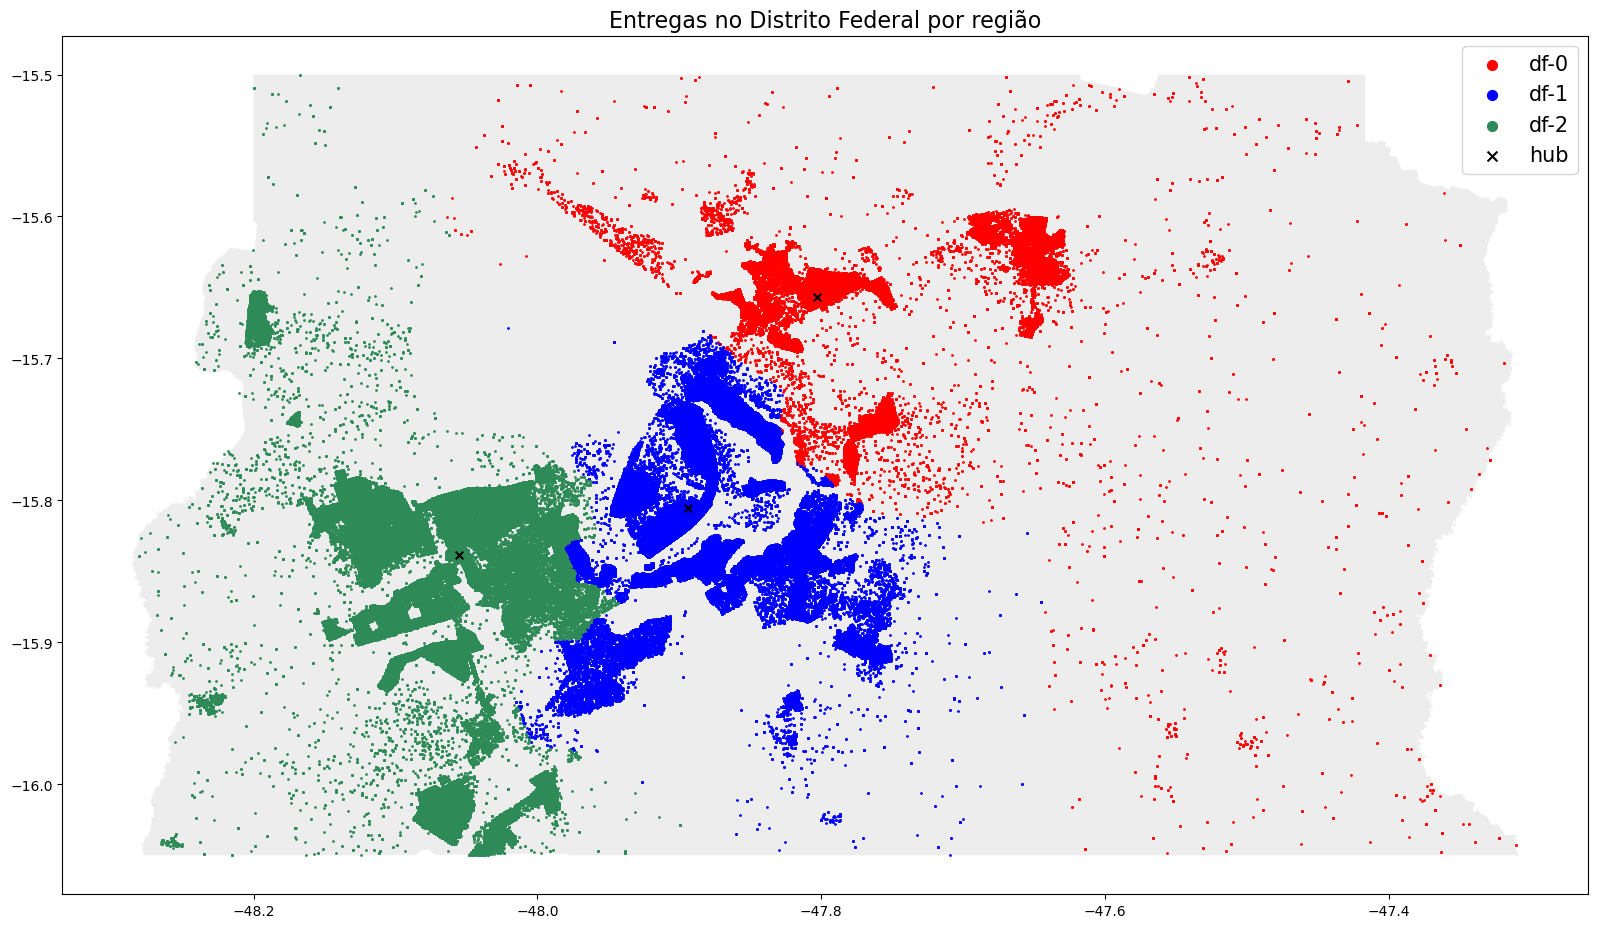

In [ ]:
mapa = geopandas.read_file('distrito-federal.shp')
mapa = mapa.loc[[0]]

#Hub map
hub_df = deliveries_df[['region', 'hub_lng', 'hub_lat']].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df['hub_lng'], hub_df['hub_lat']))

#Delivery map
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df['delivery_lng'], deliveries_df['delivery_lat']))

#Create empty plot
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

#Plot Distrito Federal map
mapa.plot(ax=ax, alpha=0.4, color='lightgrey')

#Plot delivery map
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color='red', label='df-0')
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color='blue', label='df-1')
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color='seagreen', label='df-2')

#Hub plot
geo_hub_df.plot(ax=ax, markersize=30, marker='x', color='black', label='hub')

#Title plot
plt.title('Entregas no Distrito Federal por região', fontdict={'fontsize':16})
lgnd = plt.legend(prop={'size':15})
for handle in lgnd.legendHandles:
  handle.set_sizes([50])

### 3.1\. Delivery chart by region


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  """


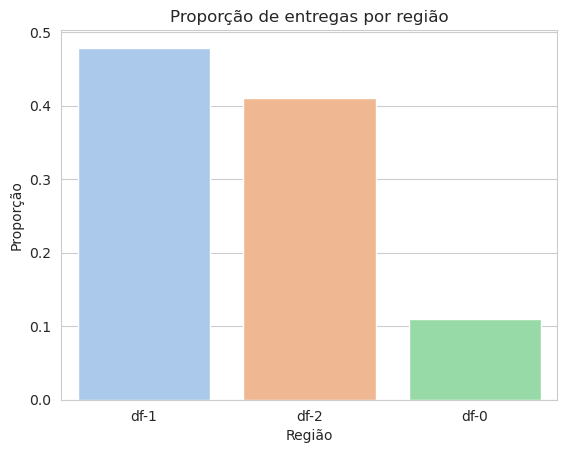

In [ ]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0:'region_percent'}, inplace=True)

with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x='region', y='region_percent', ci=None, palette='pastel')
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

### 4\. Conclusion


The df-0 is the region with the lowest concentration of deliveries when compared to df-1 and df-2. However, as it is a rural area, delivery points are farther apart from each other, which raises the question of whether it is really necessary to deploy vehicles with the same delivery capacity of df-1 and df-2 to this region. Moving part of the fleet designated for df-0 to the other two regions may result in increased delivery performance in those areas with higher flow. By analyzing the bar graph and delivery map, it is possible to see that some vehicles in df-0 may not be reaching their maximum potential due to the low number of deliveries. It would be necessary to establish a relation between the time spent on these longer deliveries, the total number of deliveries from that area and how many vehicles would be necessary to attend this demand, in order to determine the need for relocation of the df-0 fleet.